In [110]:
# import packages

import gc
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format # disabling scientific notation in pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
import optuna

gc.enable()

In [2]:
X_train = pd.read_csv("data/X_train.csv", index_col=0) 
y_train = pd.read_csv("data/y_train.csv", index_col=0) 


In [18]:
non_cat = ['visitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'device_isMobile', 'date_dow', 'date_hours', 'date_dom', 'month', 'days_since_visit']

In [19]:
cat_vars = [c for c in X_train.columns if c not in non_cat]

In [14]:
X_train.columns

Index(['channelGrouping', 'visitNumber', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'date_dow', 'date_hours', 'date_dom', 'month',
       'days_since_visit', 'source_country', 'campaign_medium',
       'browser_category', 'browser_os',
       'device_deviceCategory_channelGrouping', 'channelGrouping_browser',
       'channelGroupi

In [79]:
from sklearn.metrics import fbeta_score#, recall_score, roc_auc_score, pr

def lgb_f2_score(y_true, y_pred):
    
    y_pred = np.round(y_pred) # scikits fbeta doesn't like probabilities as they are continuous
    return 'f2', fbeta_score(y_true, y_pred, beta=2), True #https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier.fit

In [81]:
train_x, eval_x, train_y, eval_y = train_test_split(X_train, y_train, test_size=0.1)

clf = lgb.LGBMClassifier(objective="binary", n_estimators=1000)
eval_set = [(eval_x, eval_y)]

In [82]:
clf.fit(
    train_x,
    train_y,
    eval_set=eval_set,
    early_stopping_rounds=300,
    eval_metric=lgb_f2_score,
)

/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. 

[1]	valid_0's binary_logloss: 0.0456339	valid_0's f2: 0.0786211
[2]	valid_0's binary_logloss: 0.0431875	valid_0's f2: 0.0786211
[3]	valid_0's binary_logloss: 0.0413935	valid_0's f2: 0.0785973
[4]	valid_0's binary_logloss: 0.0399604	valid_0's f2: 0.081448
[5]	valid_0's binary_logloss: 0.0386895	valid_0's f2: 0.0945662
[6]	valid_0's binary_logloss: 0.0376287	valid_0's f2: 0.11742
[7]	valid_0's binary_logloss: 0.036702	valid_0's f2: 0.130101
[8]	valid_0's binary_logloss: 0.0358969	valid_0's f2: 0.13852
[9]	valid_0's binary_logloss: 0.0352182	valid_0's f2: 0.149341
[10]	valid_0's binary_logloss: 0.0346191	valid_0's f2: 0.175464
[11]	valid_0's binary_logloss: 0.0340844	valid_0's f2: 0.181766
[12]	valid_0's binary_logloss: 0.0335962	valid_0's f2: 0.187158
[13]	valid_0's binary_logloss: 0.0331782	valid_0's f2: 0.192253
[14]	valid_0's binary_logloss: 0.0327448	valid_0's f2: 0.196219
[15]	valid_0's binary_logloss: 0.0323933	valid_0's f2: 0.197425
[16]	valid_0's binary_logloss: 0.0320787	valid_0

LGBMClassifier(n_estimators=1000, objective='binary')

In [83]:
X_test = pd.read_csv("data/X_test.csv", index_col=0) 
y_test = pd.read_csv("data/y_test.csv", index_col=0) 

In [84]:
test_pred = clf.predict(X_test)

In [86]:
fbeta_score(y_test, test_pred, beta=2)

0.2807051159225905

In [104]:
importances_df = pd.DataFrame()
importances_df['feature'] = X_train.columns
importances_df['gain'] = clf.booster_.feature_importance(importance_type='gain')
importances_df['split'] = clf.booster_.feature_importance(importance_type='split')

In [106]:
importances_df['gain_log'] = np.log1p(importances_df['gain'])
importances_df['split_log'] = np.log1p(importances_df['split'])

<AxesSubplot:xlabel='gain_log', ylabel='feature'>

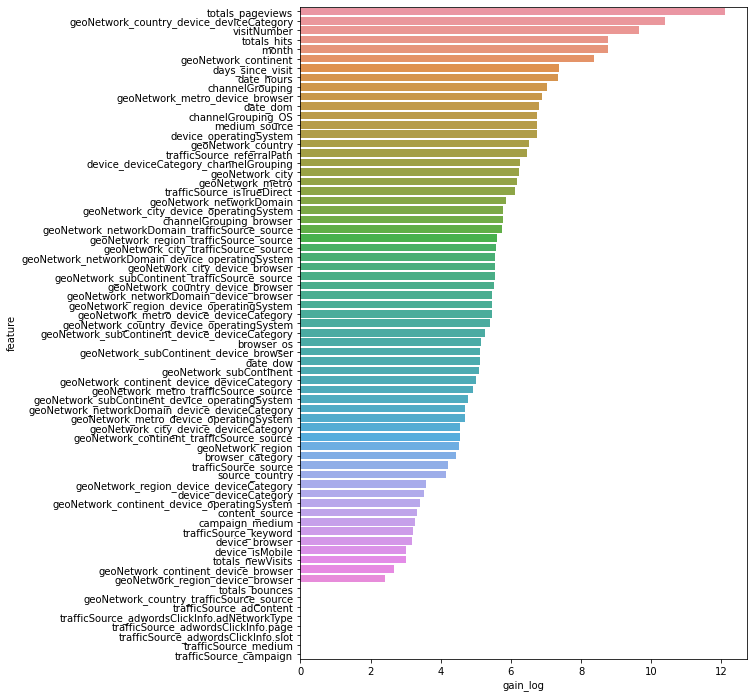

In [109]:
plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances_df.sort_values('gain_log', ascending=False))

In [108]:
importances_df

,feature,gain,split,gain_log,split_log
0,channelGrouping,"1,122.71",7,7.02,2.08
1,visitNumber,"15,551.77",95,9.65,4.56
2,totals_bounces,0.00,0,0.00,0.00
3,totals_hits,"6,491.16",127,8.78,4.85
4,totals_newVisits,19.13,1,3.00,0.69
...,...,...,...,...,...
64,geoNetwork_subContinent_device_deviceCategory,190.93,4,5.26,1.61
65,geoNetwork_subContinent_device_operatingSystem,116.29,4,4.76,1.61
66,geoNetwork_subContinent_trafficSource_source,253.25,6,5.54,1.95
67,content_source,26.57,2,3.32,1.10


In [111]:
from optuna.integration import LightGBMPruningCallback

In [117]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

In [119]:
np.empty(5)

,revenue_generated
883916,0
523510,0
770973,0
725225,0
551144,0
...,...
348837,0
383292,0
798874,0
451446,0


In [123]:
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print(idx)
    print(train_idx)
    print(test_idx)
    print(X_train.iloc[test_idx])

0
[     0      1      3 ... 631925 631926 631927]
[     2      5     13 ... 631910 631915 631922]
        channelGrouping  visitNumber       totals_bounces  totals_hits  \
770973                1            1                 0.00            3   
69367                 1           18                 0.00            4   
507047                1            1                 1.00            1   
589479                2            1                 1.00            1   
679561                2            1                 0.00            2   
...                 ...          ...                  ...          ...   
216027                0           15                 0.00           33   
240290                0            1                 0.00            2   
107227                1            1                 0.00            2   
478330                0            1                 0.00           14   
180662                1            1                 1.00            1   

           to

In [143]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        train_x, test_x = X.iloc[train_idx], X.iloc[test_idx]
        train_y, test_y = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            train_x,
            train_y,
            eval_set=[(test_x, test_y)],
            eval_metric=lgb_f2_score,
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, 'f2') 
            ],  # Add a pruning callback
        )
        preds = model.predict(test_x)
        cv_scores[idx] = fbeta_score(test_y, preds,beta=2)

    return np.mean(cv_scores)

In [144]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train.to_numpy().ravel()) ## does not like dataframes as ys
study.optimize(func, n_trials=20)

[I 2023-02-04 23:06:20,774] A new study created in memory with name: LGBM Classifier
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callbac

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_gain_to_split is set=12.28938492223492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.28938492223492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_gain_to_split is set=12.28938492223492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.28938492223492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_gain_to_split is set=12.28938492223492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.28938492223492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_gain_to_split is set=12.28938492223492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.28938492223492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_gain_to_split is set=8.02490565180254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.02490565180254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_gain_to_split is set=8.02490565180254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.02490565180254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_gain_to_split is set=8.02490565180254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.02490565180254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_gain_to_split is set=8.02490565180254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.02490565180254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_gain_to_split is set=8.02490565180254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.02490565180254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=1.5838462287747608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5838462287747608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=1.5838462287747608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5838462287747608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=1.5838462287747608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5838462287747608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=1.5838462287747608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5838462287747608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=1.5838462287747608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5838462287747608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] min_gain_to_split is set=3.7527486438142943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7527486438142943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] min_gain_to_split is set=3.7527486438142943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7527486438142943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] min_gain_to_split is set=3.7527486438142943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7527486438142943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] min_gain_to_split is set=3.7527486438142943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7527486438142943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] min_gain_to_split is set=3.7527486438142943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7527486438142943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] min_gain_to_split is set=2.414862921892822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.414862921892822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] min_gain_to_split is set=2.414862921892822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.414862921892822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] min_gain_to_split is set=2.414862921892822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.414862921892822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] min_gain_to_split is set=2.414862921892822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.414862921892822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] min_gain_to_split is set=2.414862921892822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.414862921892822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] min_gain_to_split is set=6.231173836870788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.231173836870788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


[I 2023-02-04 23:35:48,284] Trial 5 pruned. Trial was pruned at iteration 15.
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-04 23:36:02,380] Trial 6 pruned. Trial was pruned at iteration 29.
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] min_gain_to_split is set=12.998921658526529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.998921658526529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] min_gain_to_split is set=12.998921658526529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.998921658526529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] min_gain_to_split is set=12.998921658526529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.998921658526529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] min_gain_to_split is set=12.998921658526529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.998921658526529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] min_gain_to_split is set=5.615034786824323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.615034786824323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


[I 2023-02-04 23:39:58,896] Trial 8 pruned. Trial was pruned at iteration 5.
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-04 23:40:09,603] Trial 9 pruned. Trial was pruned at iteration 5.
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1,

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=3.1647746391081357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1647746391081357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=3.1647746391081357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1647746391081357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=3.1647746391081357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1647746391081357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=3.1647746391081357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1647746391081357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is 

[LightGBM] [Warning] Unknown parameter: used_ram_limit
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_gain_to_split is set=1.1973867040578852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1973867040578852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[I 2023-02-04 23:42:34,004] Trial 13 pruned. Trial was pruned at iteration 5.
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-04 23:42:40,416] Trial 14 pruned. Trial was pruned at iteration 5.
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.

In [ ]:
Trial 12 finished with value: 0.5502774609810496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.293209130675182, 'num_leaves': 2180, 'max_depth': 9, 'min_data_in_leaf': 3600, 'lambda_l1': 0, 'lambda_l2': 25, 'min_gain_to_split': 3.1647746391081357, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 12 with value: 0.5502774609810496.

In [8]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_train,y_train, test_size=0.3)

    params = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "5gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    pool_train = Pool(train_x, 
                      train_y,
                      cat_features = cat_features)
    
    pool_test = Pool(valid_x, 
                     cat_features = cat_features)

    
    lgb = lgb.LGBMClassifier(**params)
    
    lgb.fit(pool_train, 
            verbose=0, 
            early_stopping_rounds=100)
    
    preds = lgb.predict(pool_test)

    y_pred = np.rint(preds)
    fbeta = fbeta_score(valid_y, y_pred,beta=2)
    
    return fbeta